#«Космические братья» — формирование модели монетизации

#Материалы

[Презентация](https://docs.google.com/presentation/d/1arHQVUOEML2DItJyeZFTeohSHqF3mnf3vwo_R8brdlg/edit?usp=sharing)

[Дашборд](https://public.tableau.com/profile/dmitry8536#!/vizhome/game_16188486936330/sheet3_1?publish=yes)


##Описание проекта
Сформировать модель монетизации игрового приложения.
Многие игры зарабатывают с помощью рекламы. И все они сталкиваются с противоречием:

* пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет;
* но чем позже создатели игры включат рекламу, тем меньше они заработают.

Аналитик помогает бизнесу выбрать оптимальное время для запуска рекламы. Зная расходы на продвижение игры, мы можем рассчитать её окупаемость при разных сценариях.

Пока создатели игры планируют показывать её на экране выбора постройки.

Поможем им не уйти в минус:
1. Проведем исследовательский анализ данных.
2. Проанализируем влияние событий на совершение целевого события.
3. Проверим статистические гипотезы:
    
    
* различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком;
* динамика строительства зданий у клиентов с вероятностью ухода и в среднем по остальной выборке.

## Шаг 1. Загрузим данные и подготовим их к анализу

##Описание данных
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
* Победа над первым врагом
* Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет game_actions.csv:
* event_datetime — время события;
* event — одно из трёх событий: 
1.	building — объект построен,
2.	finished_stage_1 — первый уровень завершён,
3.	project — проект завершён;
* building_type — один из трёх типов здания: 
1.	assembly_shop — сборочный цех,
2.	spaceport — космопорт,
3.	research_center — исследовательский центр;
* user_id — идентификатор пользователя;
* project_type — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет ad_cost.csv содержит колонки:
* day - день, в который был совершен клик по объявлению
* source - источник трафика
* cost - стоимость кликов

Датасет user_source.csv содержит колонки:
* user_id - идентификатор пользователя
* source - источников, с которого пришёл пользователь, установивший приложение

In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
pd.options.mode.chained_assignment = None # default='warn'

Чтение файлов

In [247]:
# costs=pd.read_csv('/datasets/ad_costs.csv')
# events=pd.read_csv('/datasets/game_actions.csv')
# ab_participants=pd.read_csv('/datasets/user_source.csv')

In [248]:
from google.colab import drive
drive.mount('/content/drive')
costs=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/01_monetization_model/data/ad_costs.csv')
events=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/01_monetization_model/data/game_actions.csv')
source=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/12_Финальный проект/01_monetization_model/data/user_source.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Создадим класс со свойствами шрифтов:

In [249]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [250]:
df_list = [costs, events, source]
for df in df_list:
    print(color.BOLD + color.PURPLE+'Первые 5 строк датафрейма')
    print('-'*80)
    display(df.head(5))
    print('-'*80)
    print('Размер датафрейма: (строк:столбцов) {}'.format(df.shape))
    print('-'*80)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*80)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*80)
    print('Наличие пропусков')
    print('-'*80)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*80)
    display(df.describe())

Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (28, 3)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
source    0
day       0
cost      0
dtype: int64
Стат данные
----------------------------------------------------------------------

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (135640, 5)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 1
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
event_

,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-04 04:02:30,building,spaceport,ff841992-d93b-462e-bc6e-18c24a514f36,satellite_orbital_assembly
freq,4,127957,59325,22,1866


Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


--------------------------------------------------------------------------------
Размер датафрейма: (строк:столбцов) (13576, 2)
--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 0
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
user_id    0
source     0
dtype: int64
Стат данные
--------------------------------------------------------------------------------


,user_id,source
count,13576,13576
unique,13576,4
top,432ca5c7-c2f6-46ab-a620-25e553bef071,yandex_direct
freq,1,4817


1. Названия столбцов: корректировка не требуется.
2. Типы данных: необходимо сконвертировать столбцы в формат даты в датасетах costs и events.
3. Дубликаты: имеется 1 дубликат в датасете events.
4. Пропуски: в датасете events в колонках `building_type` и `project_type`
5. Аномалии в данных: на первый взгляд отсутствуют.

* Сконвертируем столбцы в формат даты в датасетах costs и events

In [251]:
costs['day'] = costs['day'].astype('datetime64[s]')
events['event_datetime'] = events['event_datetime'].astype('datetime64[s]')

In [252]:
df_list = [events,costs]
for df in df_list:   
    print('Типы данных и общая информация')
    print(df.info())

Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
None
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ b

* Удалим 1 дубликат

In [253]:
events=events.drop_duplicates()

In [254]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


* Обработаем пропуски в данных:

в колонке `building_type`:

In [255]:
omis_bt=events[events['building_type'].isnull()]

In [256]:
omis_bt.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,event_datetime,event,building_type,user_id,project_type
count,7683,7683,0,7683,1866
unique,7663,2,0,5817,1
top,2020-05-13 13:38:29,finished_stage_1,NaN,032557ae-ba95-4ab7-8298-50f9c89b8c00,satellite_orbital_assembly
freq,2,5817,NaN,2,1866
first,2020-05-04 19:47:29,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


Колонка `event` содержит только 2 уникальных значения, посмотрим на них:

In [257]:
omis_bt['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

В данных имеются только значения `finished_stage_1` и `project`, подсчитаем их количество по датасету в целом:

In [258]:
fs_len=len(events[events['event'] == 'finished_stage_1'])
pr_len=len(events[events['event'] == 'project'])
fs_len+pr_len

7683

Пропуски в колонке `building_type` обусловлены тем, что для событий `finished_stage_1` и `project` не происходит строительства какого-либо здания, а соответственно с этими пропусками ничего делать не будем.

в колонке `project_type`:

In [259]:
omis_pr=events[events['project_type'].isnull()]

In [260]:
omis_pr.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,event_datetime,event,building_type,user_id,project_type
count,133773,133773,127956,133773,0
unique,127004,2,3,13576,0
top,2020-05-09 08:39:32,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,NaN
freq,4,127956,59325,21,NaN
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


Колонка `event` содержит только 2 уникальных значения, посмотрим на них:

In [261]:
omis_pr['event'].unique()

array(['building', 'finished_stage_1'], dtype=object)

Видим, что для данной выборки отсутствует значение `project`, посмотим их количество в общем датасете:

In [262]:
pr_len

1866

Значение `project` в колонке `event` полностью соответствует заполненным данным с типом проекта `satellite_orbital_assembly`, соответственно данные верны и обработка пропусков не требуется.

## Шаг 2. Построим отчёты и посчитаем метрики

###2.1. Продукт

* Построим на количество пользователей по дням

In [263]:
events.columns

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')

In [264]:
events['session_date'] = events['event_datetime'].dt.date

In [265]:
dau_total = events.groupby('session_date').agg({'user_id': 'nunique'})

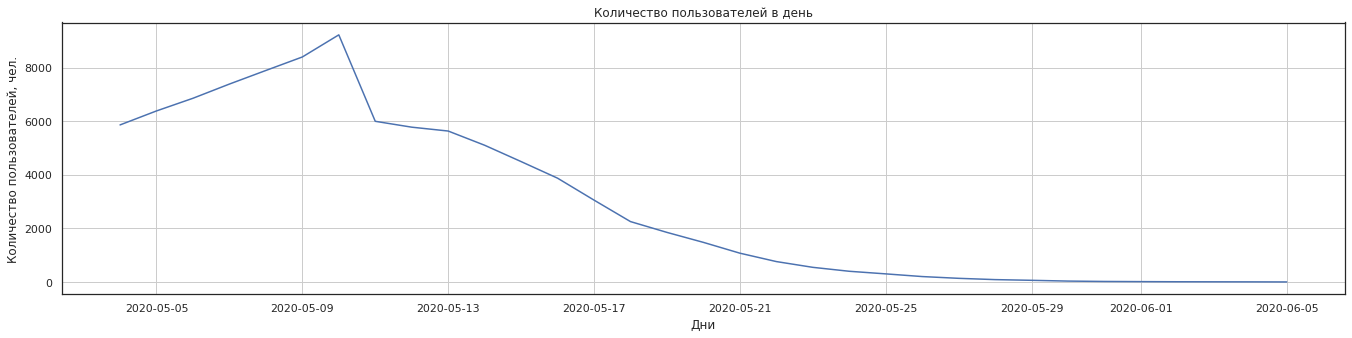

In [266]:
dau_total.plot(grid=True, title='Количество пользователей в день', figsize=(23, 5),legend=False)
plt.gca().set(xlabel='Дни', ylabel='Количество пользователей, чел.')
plt.show()

In [267]:
dau_total.describe()

,user_id
count,33.000000
mean,2884.878788
std,3083.784493
min,4.000000
25%,91.000000
50%,1480.000000
75%,5776.000000
max,9219.000000


В выборке отмечаем увеличение количества пользователей в день до 2020-05-10 в размере до 9219 человек, но 11 мая 2020 произошел резкий спад количества игроков. Возможно из - за окончания выходных, а возможно из - за окончания рекламной компании, которая проводилась:


In [268]:
print('с {:%d.%m.%Y} по {:%d.%m.%Y}'.format(costs['day'].min(), costs['day'].max()))

с 03.05.2020 по 09.05.2020


* Построим гистограмму, отображающую количество событий по дням


In [269]:
dau_total_events = events.groupby('session_date').agg({'event': 'count'})

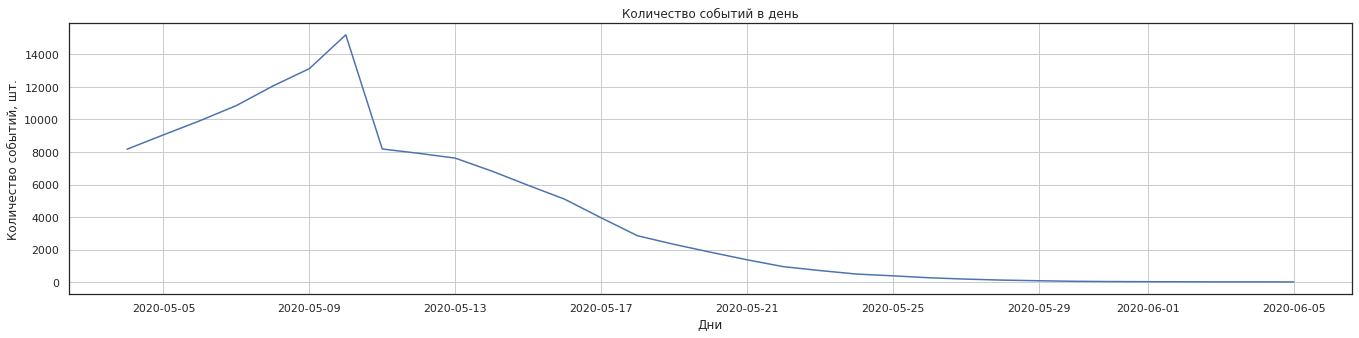

In [270]:
dau_total_events.plot(grid=True, title='Количество событий в день', figsize=(23, 5),legend=False)
plt.gca().set(xlabel='Дни', ylabel='Количество событий, шт.')
plt.show()

In [271]:
dau_total_events.describe()

,event
count,33.000000
mean,4110.272727
std,4639.714311
min,5.000000
25%,118.000000
50%,1837.000000
75%,7918.000000
max,15207.000000


График количества событий коррелирует с графиком количества пользователей в день - до 2020-05-10 достигает 15 207 событий, но к 2020-06-05 этот показатель снижается до 5.

* Сколько в среднем событий приходится на пользователя?

In [272]:
events_per_user=events.groupby('user_id').agg({'event': 'count'}).mean()
print(f'{int(events_per_user)} событий')

9 событий


* Построим график распределения количества построенных объектов

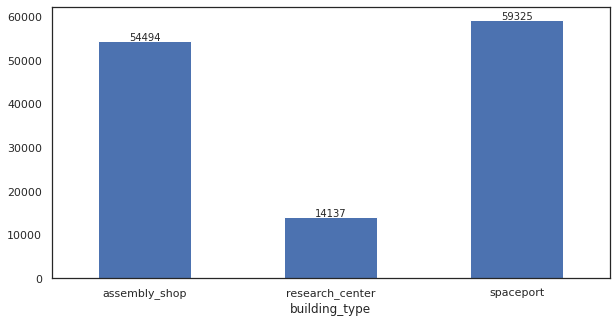

In [273]:
events_by_building_type=events.groupby('building_type')['user_id'].count().reset_index()

ax=events_by_building_type.plot(x='building_type', y='user_id', kind='bar', figsize=(10, 5), rot=360)
ax.get_legend().remove()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 5,
            '{:.0f}'.format(height),
            fontsize=10,
            ha="center")
plt.show()

Больше всего было построено spaceport, за ними идут assembly_shop, research_center строят в разы меньше.

* Посмотрим на средние количество построенных зданий в трех группах пользователей:

завершивших проект:

In [274]:
events_pr=events.query('event=="project"')

In [275]:
users_pr=events_pr['user_id'].unique()

In [276]:
round(events[events['user_id'].isin(users_pr)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    12.65
dtype: float64

победивших врага:


In [277]:
events_fs=events.query('event=="finished_stage_1"')

In [278]:
users_fs=events_fs['user_id'].unique()

In [279]:
round(events[events['user_id'].isin(users_fs)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    10.45
dtype: float64

не прошедших первый уровень:

In [280]:
events_not_win=events[~events['user_id'].isin(users_fs)][~events[~events['user_id'].isin(users_fs)]['user_id'].isin(users_pr)]

In [281]:
users_not_win=events_not_win['user_id'].unique()

In [282]:
round(events[events['user_id'].isin(users_not_win)].groupby('user_id').agg({'building_type': 'count'}).mean(),2)

building_type    8.66
dtype: float64

Пользователи, не прошедшие 1ый уровень строят зданий меньше.

###2.2. Маркетинг

* Построим график, отображающий количество пользователей, пришедших из разных рекламных источников


Для начала добавим в датасет source дату первого входа в игру - `first_enter`:

In [283]:
first_enter = events.groupby(['user_id'])['session_date'].min()
first_enter.name = 'first_enter'
source = source.join(first_enter,on='user_id')

Подсчитаем количество пользователей по каждому источнику рекламы:

In [284]:
users_per_source=source.groupby(['source']).agg({'user_id':'nunique'}).reset_index()
users_per_source.columns=['source', 'users_number']

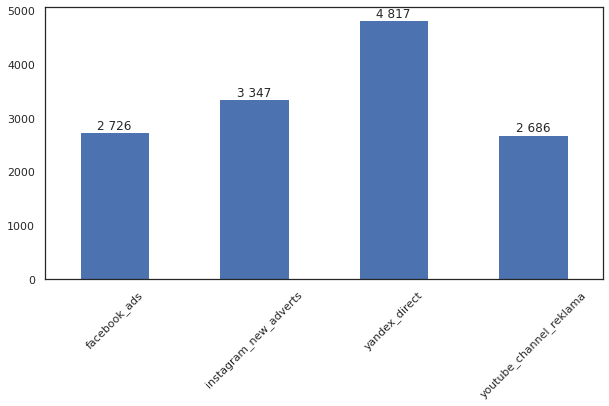

In [285]:
ax = users_per_source.plot(y='users_number', kind='bar', figsize=(10, 5))
ax.set_xticklabels(users_per_source['source'], rotation=45)
ax.get_legend().remove()
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), ',').replace(',', ' '),
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

Большинство пользователей пришли из yandex_direct.

* Сколько денег потратили

In [286]:
print('Всего трат -', round(costs['cost'].sum(),2))

Всего трат - 7603.58


* Сколько стоило привлечение одного покупателя из каждого источника

Подсчитаем количество пользователей по дате первого входа в игру и источнику рекламы:

In [287]:
users_date_source=source.groupby(['first_enter', 'source']).agg({'user_id': 'nunique'}).reset_index()
users_date_source.columns=['first_enter','source', 'users_number']

Переведем столбец с датой в соответствующий формат:

In [288]:
users_date_source['first_enter'] = users_date_source['first_enter'].astype('datetime64[s]')

Т.к. известно, что дата рекламных затрат предшествует дате первого входа в игру, то создадим дополнительный столбец для выравнивания дат:

In [289]:
users_date_source['shifted_date'] = users_date_source['first_enter'] - pd.Timedelta(days=1)

Объединим полученный датасет с данными по затратам:

In [290]:
costs = pd.merge(costs, users_date_source,  how='left', left_on=['day','source'], right_on = ['shifted_date','source'])

Сгруппируем данные по источнику рекламы и просуммируем затраты и количество пользователей:

In [291]:
costs_source=costs.groupby('source').agg({'cost':'sum', 'users_number':'sum'}).reset_index()

Теперь рассчитаем CAC по рекламному источнику:

In [292]:
costs_source['cac'] = costs_source['cost'] / costs_source['users_number']
costs_source

,source,cost,users_number,cac
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


Диапазон затрат на привлечение 1 пользователя разнится от 0,40 до 0,79, самым выгодным источником является youtube_channel_reklama.

## Шаг 3. Проверим гипотезы

###3.1. Различие времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком


Выведем в отдельную колонку разницу во времени с момента начала игры и до момента прохождения 1го уровня.

Для этого в датасет events добавим колонку `first_enter`:

In [293]:
events = events.join(first_enter,on='user_id')

Удалим нерелевантные события из датасета:

In [294]:
events_winners = events.drop(events[events['event'] == 'building'].index)

Переведем столбец с датой `first_enter` в соответствующий формат:

In [295]:
events_winners['first_enter'] = events_winners['first_enter'].astype('datetime64[s]')

А теперь добавим колонку `winner_time`:

In [296]:
events_winners['winner_time']=events_winners['event_datetime']-events_winners['first_enter']

Добавим колонку со временем в секундах:

In [297]:
events_winners['winner_time_sec'] = events_winners['winner_time'].dt.total_seconds()

Посмотрим на распределение этого показателя по двум группам пользователей:

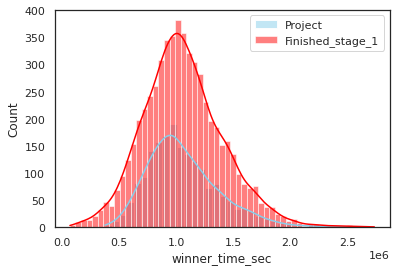

In [298]:
sns.histplot(data=events_winners, x=events_winners.query('event=="project"')['winner_time_sec'], color="skyblue", label="Project", kde=True)
sns.histplot(data=events_winners, x=events_winners.query('event=="finished_stage_1"')['winner_time_sec'], color="red", label="Finished_stage_1", kde=True)

plt.legend() 
plt.show()

Воспользуемся T-тестом для разности двух средних.

H0: Время прохождения одинаково

H1: Время прохождения различно

In [299]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    events_winners.query('event=="project"')['winner_time_sec'],
    events_winners.query('event=="finished_stage_1"')['winner_time_sec'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8465034211737528
Не получилось отвергнуть нулевую гипотезу


Отсутствуют статистически значимые различия средних значений времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

###3.2. Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по остальной выборке

Для проверки этой гипотезы нужно сперва обозначить пользователей, которые с большой долей вероятности прекратят пользоваться игрой.

Основной активностью в игре является постройка зданий. Сперва сгруппируем данные по когорте `first_enter` и дате постройки зданий `session_date`:

In [300]:
buildings_grouped_by_cohorts = events.query('event=="building"').groupby(
    ['first_enter', 'session_date']
).agg({'user_id': 'nunique', 'event': 'count'}).reset_index()
buildings_grouped_by_cohorts.columns=['first_enter', 'session_date','users_number', 'events_number']

Определим среднее количество построек у одного пользователя `buildings_per_user`:

In [301]:
buildings_grouped_by_cohorts['buildings_per_user'] = (
    buildings_grouped_by_cohorts['events_number']
    / buildings_grouped_by_cohorts['users_number']
)

Найдём lifetime когорты. Из даты постройки здания `session_date` вычтем дату когорты `first_enter`:

In [302]:
buildings_grouped_by_cohorts = buildings_grouped_by_cohorts
buildings_grouped_by_cohorts['cohort_lifetime'] = (
    (buildings_grouped_by_cohorts['session_date']
    - buildings_grouped_by_cohorts['first_enter'])/ np.timedelta64(1, 'D')
)
buildings_grouped_by_cohorts['cohort_lifetime'] = buildings_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

Построим сводную таблицу изменения среднего количества построенных зданий, где в столбцах будет lifetime, а строках — когорты:

In [303]:
buildings_per_user_pivot = buildings_grouped_by_cohorts.pivot_table(
    index='first_enter',
    columns='cohort_lifetime',
    values='buildings_per_user',
    aggfunc='mean',
)

Построим тепловую карту:

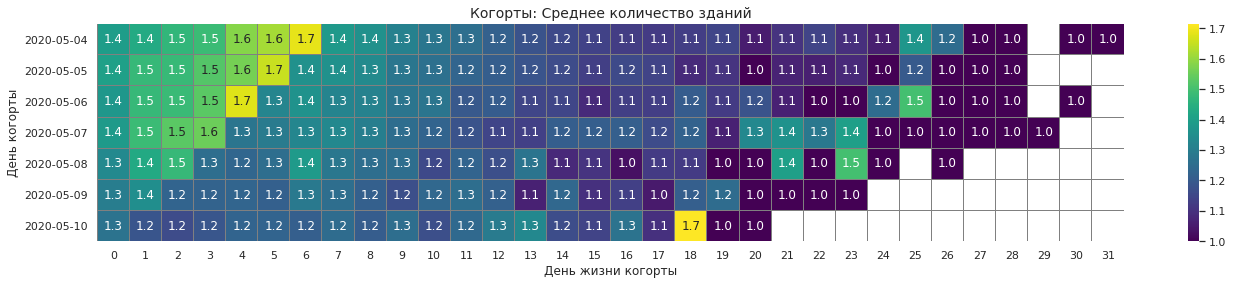

In [304]:
sns.set(style='white')
plt.figure(figsize=(23, 4))
plt.title('Когорты: Среднее количество зданий', size=14)
ax=sns.heatmap(buildings_per_user_pivot, annot=True, fmt='.1f', linewidths=.01, linecolor='gray', cmap="viridis")
ax.set_ylabel('День когорты')
ax.set_xlabel('День жизни когорты')
plt.show()

Максимальное среднее количество простроенных зданий в день - 1,7.

Добавим признак `churn` по пользователям у которых с даты последнего события прошло от 3 недель и проверим гипотезу.

Найдем последнее событие по каждому пользователю:

In [305]:
last_enter = events.groupby(['user_id'])['session_date'].max()
last_enter.name = 'last_enter'
last_enter=last_enter.to_frame().reset_index()

Подсчитаем количество дней в течение которых пользователь неактивен:

In [306]:
last_enter['na_days']=events['session_date'].max()-last_enter['last_enter']
last_enter['na_days']=last_enter['na_days'].dt.days

Добавим колонку `churn`:

In [307]:
def churn_flag(row):
    if row['na_days']>= 21:
        return 1
    return 0
last_enter['churn'] = last_enter.apply(churn_flag, axis=1)

Добавим маркер `churn` в датасет events:

In [308]:
events = events.merge(last_enter,on='user_id')

Воспользуемся T-тестом для разности двух средних.

H0: Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по выборке одинакова

H1: Динамика строительства зданий у клиентов с вероятностью ухода и в среднем по выборке различна

In [309]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    events.query('churn==0').groupby('user_id').agg({'building_type': 'count'}).reset_index()['building_type'],
    events.query('churn==1').groupby('user_id').agg({'building_type': 'count'}).reset_index()['building_type'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Выдвинутая гипотеза подтвердила различие в динамике строительства зданий у активных пользователей и пользователей попавших в отток.

## Шаг 4. Построим модель прогнозирования оттока пользователей

###4.1. Подготовим данные

Посмотрим какие данные у нас имеются для построения прогнозной модели:
* количество построенных зданий по их типам;
* признак прохождения первого уровня;
* время отсутствия событий;
* ID источника рекламы.

Подготовим таблицу по этим признакам.

In [310]:
events=pd.merge(events, source.drop(columns=['first_enter']), on='user_id')

Присвоим каждому источнику рекламы ID, создадим таблицу forecast и начнем ее заполнение:

In [311]:
def source_ids(row):
    if row['source'] == 'youtube_channel_reklama':
        return 1
    elif row['source'] == 'facebook_ads':
        return 2
    elif row['source'] == 'instagram_new_adverts':
        return 3
    return 4
events['source_id'] = events.apply(source_ids, axis=1)

In [312]:
forecast = events[['user_id', 'source_id', 'churn']].copy().drop_duplicates()

Добавим время время отсутствия событий:

In [313]:
# forecast['na_days'] = forecast['user_id'].map(events.groupby('user_id')['na_days'].mean())

Добавим признак прохождения первого уровня:

In [314]:
forecast['win']=forecast.apply(lambda x: (x.user_id in events_winners['user_id'].tolist())*1, axis=1)

Добавим количество построенных зданий по их типам.

In [315]:
forecast['assembly_shop'] = forecast['user_id'].map(events.query('building_type=="assembly_shop"').groupby('user_id')['building_type'].count())
forecast['spaceport'] = forecast['user_id'].map(events.query('building_type=="spaceport"').groupby('user_id')['building_type'].count())
forecast['research_center'] = forecast['user_id'].map(events.query('building_type=="research_center"').groupby('user_id')['building_type'].count())

In [316]:
forecast.fillna(0, inplace=True)

In [317]:
forecast.head()

,user_id,source_id,churn,win,assembly_shop,spaceport,research_center
0,55e92310-cb8e-4754-b622-597e124b03de,1,1,0,7,0.0,0.0
7,c07b1c10-f477-44dc-81dc-ec82254b1347,2,1,1,6,3.0,2.0
20,6edd42cc-e753-4ff6-a947-2107cd560710,3,0,1,6,4.0,2.0
33,92c69003-d60a-444a-827f-8cc51bf6bf4c,2,1,0,5,3.0,2.0
43,cdc6bb92-0ccb-4490-9866-ef142f09139d,4,1,1,3,3.0,0.0


Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

###4.2. Разобьем данные на обучающую и валидационную выборку функцией `train_test_split`()

У нас есть сильная корреляция между несколькими признаками, что говорит о мультиколлениарности.
Лучше всего избавляться от одного из таких признаков, чтобы наша модель работала объективно.

In [318]:
df_del_corr = forecast.copy()
df_del_corr = df_del_corr.drop(['user_id'], axis=1)

Разделим наши данные на признаки (матрица X) и целевую переменную (y)
Применим для y атрибут `stratify`, что даст нам безопасность сохранения 20 % значений равного нужного нам количества классов в целевой переменной.


In [319]:
X=df_del_corr.drop('churn', axis=1)
y=df_del_corr['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Стандартизируем данные

In [320]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st =  scaler.transform(X_test)

###4.3. Обучим модель на train-выборке двумя способами:

* логистической регрессией

In [321]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

* случайным лесом

In [322]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

###4.4. Оценим метрики для обеих моделей на валидационной выборке

* Accuracy: доля правильных ответов
* Precision: точность (англ. precision)
* Recall: полнота
* F1_score: баланс между Precision and Recall
* ROC_AUC: доля оценки качества классификатора

Определим функцию для вывода метрик обучающих моделей

In [323]:
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [324]:
# выведем все метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities, 'Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.75
	Precision: 0.75
	Recall: 0.74
	F1: 0.75
	ROC_AUC: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.73
	Precision: 0.73
	Recall: 0.70
	F1: 0.72
	ROC_AUC: 0.79


Дополнительно посмотим на ROC_AUC

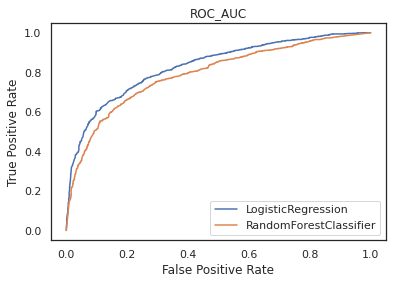

In [325]:
plt.figure(0).clf()
fpr, tpr, thresh = metrics.roc_curve(y_test, lr_probabilities)
plt.plot(fpr,tpr,label="LogisticRegression")
fpr, tpr, thresh = metrics.roc_curve(y_test, rf_probabilities)
plt.plot(fpr,tpr,label="RandomForestClassifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC')
plt.legend(loc=0)
plt.show()

Модель логистической регрессии обладает более высокими показателями метрик, а также по графику метрики ROC_AUC видим, что кривая алгоритма логистической регрессии «выгибается» к верхнему левому углу больше, то есть близка к 1, а значит является более точной.
В дальнейшем для прогнозирования можно использовать модель логистической регрессии.

##Шаг 5. Сделаем кластеризацию пользователей
---



###5.1. Стандартизируем данные

In [326]:
df_sc = scaler.fit_transform(forecast.drop(columns = ['churn','user_id'])) 

###5.2. Построим матрицу расстояний и нарисуем дендрограмму

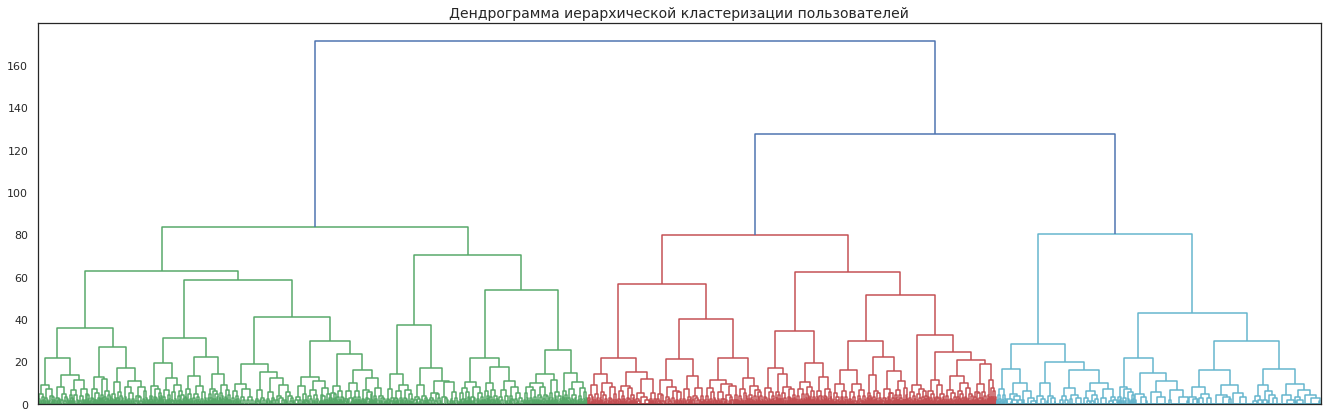

In [327]:
linked = linkage(df_sc, method = 'ward')
plt.figure(figsize=(23, 7))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма иерархической кластеризации пользователей', size=14)
plt.show() 

Предложенное оптимальное число кластеров 3 — четыре разных цвета на графике.

###5.3. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры пользователей

На основе дендрограммы зададим число кластеров равное 3, применим алгоритм к данным и сформируем вектор кластеров.

In [328]:
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(df_sc)

Сохраним метки кластера в поле `cluster_km` нашего датасета

In [329]:
forecast['cluster_km'] = labels

Оценим метрикой силуэта качество кластеризации

In [330]:
df_sc = scaler.fit_transform(forecast.drop(columns = ['user_id']))
silhouette_score(df_sc, labels)

0.2687912036366772

Качество кластеризации слабое.

###5.4. Посмотрим на средние значения признаков для кластеров

Произведем группировку данных по кластеру.

In [331]:
forecast.drop(columns = ['user_id']).groupby('cluster_km').mean().T

cluster_km,0,1,2
source_id,2.744091,2.785568,2.753410
churn,0.753330,0.342974,0.361702
win,0.068328,0.000000,1.000000
assembly_shop,2.868930,4.763950,4.516276
spaceport,2.449076,5.989191,4.987452
research_center,0.090245,1.830266,1.355155


Кластер № 0 имеет максимальную долю оттока пользователей - 75 %. Ему присущи: низкая доля игроков прошедших первый уровень и самые низкие показатели по постройке зданий.

## Шаг 6. Модель монетизации

Сформируем модель монетизации игрового приложения при условии показа рекламы на экране с выбором типа объекта для постройки.


Из этапа 2.2 мы уже знаем, что привлечение 1 пользователя разнится от 0,40 до 0,79.
А из пункта 2.1 мы знаем, что в среднем пользователи строят от 8 построек.

Значит для того, чтобы окупился даже самый дорогой в привлечении пользователь уже на первом уровне игры, то мы можем показывать рекламу на экране с выбором типа объекта для постройки за 0,1.

Смоделируем такой вариант и посмотрим на получившиеся метрики.

###6.1. Прогнозирование LTV


In [332]:
buildings_grouped_by_cohorts['revenue']=buildings_grouped_by_cohorts['events_number']*0.1

Найдём LTV. Разделим валовую прибыль когорт за каждый день на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде тепловой карты:

In [333]:
buildings_grouped_by_cohorts['ltv'] = buildings_grouped_by_cohorts['revenue'] / buildings_grouped_by_cohorts['users_number']
    
output = buildings_grouped_by_cohorts.pivot_table(
        index='first_enter', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
output=output.cumsum(axis=1).round(2)

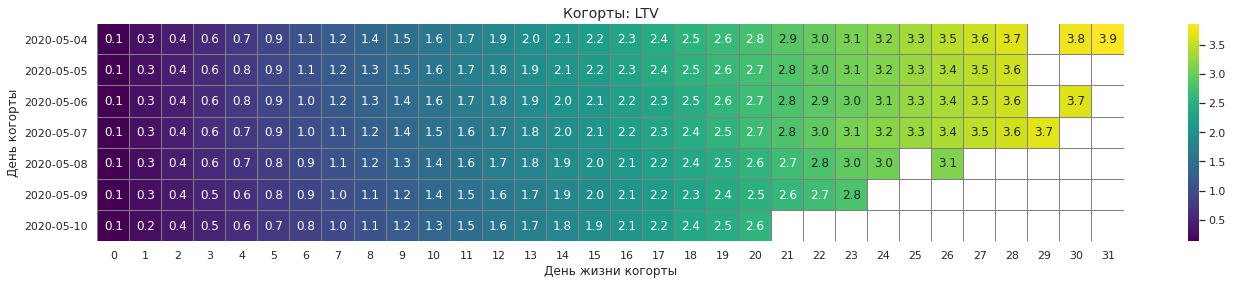

In [334]:
sns.set(style='white')
plt.figure(figsize=(23, 4))
plt.title('Когорты: LTV', size=14)
ax=sns.heatmap(output, annot=True, fmt='.1f', linewidths=.01, linecolor='gray', cmap="viridis")
ax.set_ylabel('День когорты')
ax.set_xlabel('День жизни когорты')
plt.show()

###6.2. Рассчитаем ROMI по когортам


Подготовим данные:

In [335]:
events_grouped_by_cohorts = events.query('event=="building"').groupby(
    ['source','first_enter','session_date']
).agg({'user_id': 'nunique', 'event': 'count'}).reset_index()
events_grouped_by_cohorts.columns=['source','first_enter', 'session_date','users_number', 'events_number']

In [336]:
events_grouped_by_cohorts = events_grouped_by_cohorts
events_grouped_by_cohorts['cohort_lifetime'] = (
    (events_grouped_by_cohorts['session_date']
    - events_grouped_by_cohorts['first_enter'])/ np.timedelta64(1, 'D')
)
events_grouped_by_cohorts['cohort_lifetime'] = events_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [337]:
romi=pd.merge(events_grouped_by_cohorts, costs.drop(columns=['first_enter','users_number']), on='source')

Чтобы посчитать накопительный ROMI, вызовем метод cumsum() - он последовательно сложит ROMI по `cohort_lifetime`:

In [338]:
romi['cac'] = romi['cost'] / romi['users_number']
romi['ltv'] = (romi['events_number']*0.1)/romi['users_number']
romi['romi'] = romi['ltv'] / romi['cac']
output = romi.pivot_table(
        index='first_enter',  
        columns='cohort_lifetime',
        values='romi', 
        aggfunc='mean')

output=output.cumsum(axis=1).round(2)

Построим тепловую карту:

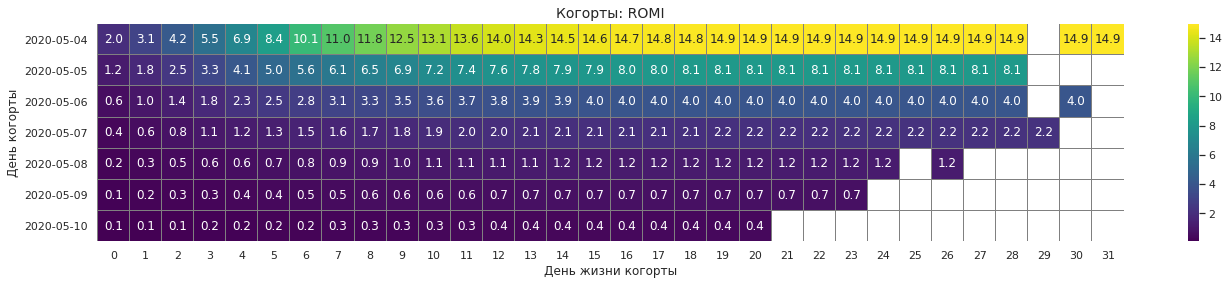

In [339]:
sns.set(style='white')
plt.figure(figsize=(23, 4))
plt.title('Когорты: ROMI', size=14)
ax=sns.heatmap(output, annot=True, fmt='.1f', linewidths=.01, linecolor='gray', cmap="viridis")
ax.set_ylabel('День когорты')
ax.set_xlabel('День жизни когорты')
plt.show()

Наблюдаем, что почти все когорты окупаются, но окупаемость падает, а значит нужно больше вкладываться в раскрутку, приобретая новых пользователей.

###6.3. Рассчитаем ROMI по источникам рекламы

Подготовим данные:

In [340]:
events_grouped_by_source = events.query('event=="building"').groupby(
    ['source']
).agg({'user_id': 'nunique', 'event': 'count'}).reset_index()
events_grouped_by_source.columns=['source', 'users_number', 'events_number']
events_grouped_by_source['revenue']=events_grouped_by_source['events_number']*0.1

In [341]:
costs_grouped_by_source=costs.groupby('source')['cost'].sum().reset_index()

In [342]:
events_grouped_by_source=pd.merge(events_grouped_by_source, costs_grouped_by_source, on='source')

Будем рассчитывать ROMI как отношение выручки к затратам на рекламу в разрезе источников рекламы.

In [343]:
events_grouped_by_source['romi']=events_grouped_by_source['revenue']/events_grouped_by_source['cost']
events_grouped_by_source

,source,users_number,events_number,revenue,cost,romi
0,facebook_ads,2726,26131,2613.1,2140.904643,1.220559
1,instagram_new_adverts,3347,31815,3181.5,2161.441691,1.471934
2,yandex_direct,4817,45032,4503.2,2233.111449,2.016559
3,youtube_channel_reklama,2686,24978,2497.8,1068.119204,2.338503


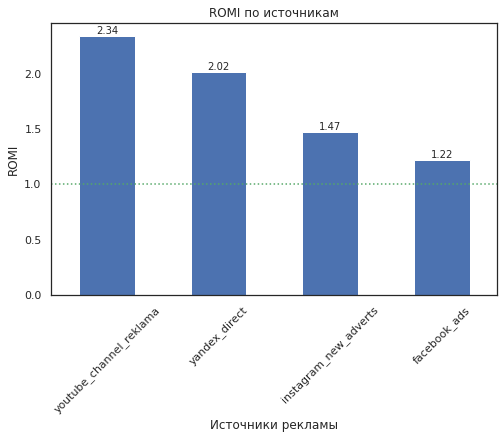

In [344]:
output = events_grouped_by_source.sort_values(by='romi', ascending=False).reset_index()

ax=output.plot(y='romi', x='source', kind='bar', figsize=(8, 5), title='ROMI по источникам', legend=False, rot=45)
plt.axhline(y=1, color='g', linestyle=':')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.02,
            '{:.2f}'.format(height),
            fontsize=10,
            ha="center")
plt.xlabel('Источники рекламы')
plt.ylabel('ROMI')
plt.show()

ROMI окупилось по всем источникам рекламы, при этом по youtube_channel_reklama и yandex_direct более чем в 2 раза.

## Шаг 7. Сформулируем выводы

При работе с проектом были выполнены следующие шаги:

1. Загружены данные и подготовлены к анализу
2. Построены отчеты и посчитаны метрики
3. Проверены гипотезы
4. Построена модель прогнозирования оттока пользователей
5. Проведена кластеризация клиентов
6. Сформирована модель монетизации игрового приложения

**Продукт**

Среднее количество пользователей игры в 1 мес. - 4 110.

Среднее количество событий на 1 пользователя в день - 9.

Больше всего было построено spaceport, за ними идут assembly_shop, research_center строят в разы меньше.

Пользователи, не прошедшие 1ый уровень строят зданий меньше.

**Маркетинг**

Большинство пользователей пришли из yandex_direct.

Общие траты на все каналы маркетинга - 7603.58

Диапазон затрат на привлечение 1 пользователя разнится от 0,40 до 0,79, самым выгодным источником является youtube_channel_reklama.


**Гипотезы**

Отсутствуют статистически значимые различия средних значений времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Динамика строительства зданий у активных пользователей и пользователей попавших в отток различна.

**Модели прогнозирования**

На основе данных мы обучили две модели по алгоритмам логистической регрессии и случайного леса. Модель логистической регрессии на валидационной выборке выдала наилучшие метрики, в дальнейшем для прогнозирования оттока клиентов можно применять именно ее.

**Кластеризация**

Все клиенты были поделены на кластеры с помощью алгоритмов агломеративной иерархической кластеризации и K-Means, дополнительно мы отметили, что: кластеру с максимальной долей оттока пользователей - 75 % присущи: низкая доля игроков прошедших первый уровень и самые низкие показатели по постройке зданий.

**Модель монетизации**

Сформирована модель монетизации игрового приложения и произведен расчет при демонстрации рекламы на экране с выбором типа объекта для постройки стоимостью - 0,1.

При этом условии LTV достигает 3,9, а также окупаются все источникам рекламы.

**Рекомендации**

* активное привлечение пользователей через youtube_channel_reklama и yandex_direct с целью увеличения количества пользователей;
* минимальная стоимость показа - 0,1.